# Cart-pole swing-up problem: interactive demonstration

Hello and welcome. This is a Jupyter Notebook, a kind of document that can alternate between static content, like text and images, and executable cells of code.

This document ilustrates the Cart-pole swing-up test case of the paper: "Collocation Methods for Second Order Systems", submitted to RSS 2022.

In order to run the cells of code, you can select the cell and clic on the small "play" button in the bar above or press shift+enter. Alternatively, you can select the option "run -> run all cells" in order to run all the code in order. Beware that some cells can take several minutes!

All of the code used in this example is open-source and free to use.

[SymPy](https://www.sympy.org/en/index.html) is used for Symbolic formulation and manipulation of the problem.

[Numpy](https://numpy.org/) is used for numerical arrays and operations.

[CasADI](https://web.casadi.org/) is used for optimization.

[Chords](https://github.com/AunSiro/optibot) is the name of the package where we are compiling our code. We aim to produce a toolbox for Optimal Control Problems, focused on robotics, including a high level, readable and clean interface between the prior three packages.

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sympy import (symbols, simplify, Matrix)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [3]:
from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack

In [4]:
from functools import lru_cache
from copy import copy

In [5]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

## Symbolic Problem Modelling

The first step is to model our problem taking advantage of the high level object syntax of the mechanics module in SymPy

In [6]:
problem_name = 'Cartpole_higher_order'

In [7]:
# Creating symbols and dynamic symbols

m0, m1, l, t, g = symbols('m_0 m_1 l t g')
q0, q1 = dynamicsymbols('q_0 q_1')

In [8]:
# Definition of the physics system

N_in = ReferenceFrame('N')
pN = Point('N*')
pN.set_vel(N_in, 0)

P0 = pN.locatenew('P0', q0 * N_in.x)
P0.set_vel(N_in, q0.diff(t) * N_in.x)
cart_part = Particle('CartPart', P0, m0)
cart_part.potential_energy = m0 * g * P0.pos_from(pN).dot(N_in.y)

N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P1 = P0.locatenew('P1', -l*N1.y)
P1.set_vel(N_in, P1.pos_from(pN).dt(N_in))

pend_part = Particle('PendPart', P1, m1)
pend_part.potential_energy = m1 * g * P1.pos_from(pN).dot(N_in.y)

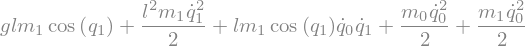

In [9]:
#Computing the Lagrangian

Lag_simp = Lagrangian(N_in, cart_part, pend_part)
Lag_simp

In [10]:
# Defining the control forces and external actions, and applying them to our system

u0, u1 = symbols('u_0, u_1')
FL = [(P0, u0 * N_in.x)]#, (N1, u1 * N_in.z)]
LM_small = SimpLagrangesMethod(Lag_simp, [q0, q1], forcelist=FL, frame=N_in)

Generating M_inv
simplifying M_inv
simplifying RHS
Model completed


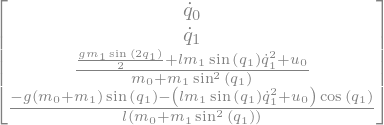

In [11]:
# Generating the dynamic equations

LM_small.form_lagranges_equations()
RHS_small = LM_small.rhs
RHS_small

### Casadi optimization

We have generated the system equations symbolicaly. Now, we translate them to CasADi objects in order to perform the optimization.

In [12]:
#Numerical values of the paramenters

m0_n, m1_n = [1., 0.3]
l_n = 0.5
g_n = 9.81
params = [g_n, l_n, m0_n, m1_n]

In [13]:
from chords.opti import Opti_Problem
from chords.analysis import interpolation, dynamic_errors
import time
from functools import lru_cache

# Translating the Sympy Expression into a CasADi function

F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

def gen_ini_guess(N = 25, ini_guess = 'lin'):
    '''
    Generates an initial guess for the Cartpole problem of N intervals.
    '''
    if ini_guess == 'zero':
        x_init_guess = np.zeros([N+1,4])
    elif ini_guess == 'lin':
        def_q1 = np.linspace(0,1,N+1)
        def_q2 = np.linspace(0,np.pi,N+1)
        def_v1 = np.zeros(N+1)
        def_v2 = np.zeros(N+1)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    return x_init_guess


import time
def chrono_solve(opti, solve_repetitions):
    '''
    Calls the solver a certain amount of times and returns the last solution
    obtained and the average computing time
    '''
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt


In [14]:
from chords.casadi import implicit_dynamic_x_to_casadi_function

In [15]:
x = dynamicsymbols('x_0:4')

In [16]:
x_d = [_i.diff() for _i in x]#symbols('\dot{x}_0:4')

In [17]:
RHSx=RHS_small.subs([
    [q0.diff(t), x[2]],
    [q1.diff(t), x[3]],
    [q0, x[0]],
    [q1, x[1]]
])

RHS_small,RHSx

In [18]:
from chords.numpy import RHS2numpy
F_nump = RHS2numpy(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [19]:
def imp_F_x_np(x, x_d, u, lambdas, params):
    x_d_f = F_nump(x, u, params)
    return x_d - x_d_f

In [20]:
x_d_mat = Matrix(x_d)

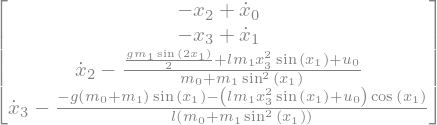

In [21]:
impl_D = x_d_mat-RHSx
impl_D

In [22]:
imp_F_x_cas = implicit_dynamic_x_to_casadi_function(impl_D, x, verbose=True)
imp_F_x_cas

x vars expected: [x_0, x_1, x_2, x_3, x_0_dot, x_1_dot, x_2_dot, x_3_dot]
x vars found: [x_0_dot, x_1, x_1_dot, x_2, x_2_dot, x_3, x_3_dot]
u vars found: [u_0]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot]
	u: [u_0]
	lambdas: []
	params: [g, l, m_0, m_1]



Function(M:(x[4],x_dot[4],u,lambdas[0],params[4])->(residue[1x4]) MXFunction)

In [23]:
from chords.piecewise import increase_order_implicit_func

In [24]:
x_example = [0,1,2,3]
u_example = [1]
x_dot_example = F_nump(x_example, u_example, params)

In [25]:
imp_F_x_cas(x_example, x_dot_example, u_example, [], params)

DM([[0, 0, 0, 0]])

In [26]:
imp_F_x_np(x_example, x_dot_example, u_example, [], params)

array([0., 0., 0., 0.])

In [27]:
x_3_example = x_example + [0,0]
x_3_dot_example = list(x_dot_example) + [0,0]

In [28]:
imp_F_x_cas_3 = increase_order_implicit_func(
    imp_F_x_cas,
    2,
    3,
    mode = 'casadi',
)
imp_F_x_np_3 = increase_order_implicit_func(
    imp_F_x_np,
    2,
    3,
    mode = 'numpy',
)

In [29]:
imp_F_x_cas_3(np.array([x_3_example,]), np.array([x_3_dot_example,]), u_example, [], params)

DM([[0, 0, -2.86535, 19.606, 0, 0]])

In [30]:
imp_F_x_np_3(np.array(x_3_example,), np.array(x_3_dot_example,), u_example, [], params)

array([ 0.        ,  0.        , -2.86535292, 19.6059743 ,  0.        ,
        0.        ])

In [31]:
import importlib
import chords
importlib.reload(chords.util)
importlib.reload(chords.bu_pseudospectral)
importlib.reload(chords.opti)
importlib.reload(chords.analysis)
importlib.reload(chords)
from chords.opti import Opti_Problem
from casadi import sum1, sum2

In [32]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, set_fonts,
                        save_fig)
set_fonts()

In [33]:
from chords.numpy import store_results
from chords.util import save_fig, plot_by_segments
from chords.piecewise import interpolated_array_derivative

In [34]:
# U initialization

tt_in = np.array([7.89876773e-04, 2.11306260e-01, 8.70550865e-01, 1.18073996e+00, 1.99921012e+00])
uu_in = np.array([  1.9055811 ,   8.9161864 , -13.86953442,   2.92946272, -1.85406161])
#tt_in, uu_in

In [35]:
q_warm = np.loadtxt('cartpole_solution_q.gz')[:,:2]
u_warm = np.loadtxt('cartpole_solution_u.gz')
t_warm = np.loadtxt('cartpole_solution_t.gz')

In [36]:
v_warm = np.gradient(q_warm, t_warm, axis = 0)
x_warm = np.concatenate((q_warm, v_warm), axis = 1)

In [37]:
@lru_cache(maxsize=None)
#@store_results
def casadi_cartpole(scheme, N, 
                    ini_guess='lin',
                    solve_repetitions = 1,
                    t_end = 2,
                    order = 2, 
                    cost_f = 'u',
                    x0 = 'qv',
                    verbose = False,
                    silent = True):
    
    if order > 2:
        imp_f = increase_order_implicit_func(
            imp_F_x_cas,
            2,
            order,
            mode = 'casadi',
        )
        n_q = 2
    else:
        imp_f = imp_F_x_cas
        n_q = 4//order
        
    _opti = Opti_Problem(
        LM=imp_f,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup('f_x_impl', n_q, 1, order = order)
    _opti.opti_setup(N)
    _opti.apply_scheme()
    
    if ini_guess == 'lin':
        if order >= 2:
            _opti.initial_guess([0,0], [1,np.pi])
        elif order == 1:
            _opti.initial_guess([0,0, 0.5 ,np.pi/2], [1,np.pi, 0.5 ,np.pi/2])
        else:
            raise ValueError()
    elif ini_guess == 'waypoints':
        if order == 2:
            _opti.initial_guess(q_warm, t_warm, u_warm)
        elif order == 1:
            _opti.initial_guess(x_warm, t_warm, u_warm)
    else:
        raise ValueError('ini_guess: ', ini_guess)
        
    
        
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    X_d = _opti.opti_arrs['x_d']
    if 'parab' in scheme:
        X_c = _opti.opti_arrs['x_c']
        X_d_c = _opti.opti_arrs['x_d_c']
        U_c = _opti.opti_arrs['u_c']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    X_d_s = _opti.opti_points['x_d_s']
    X_d_e = _opti.opti_points['x_d_e']
    
    if cost_f == 'u':
        arr = U**2
        if 'parab' in scheme:
            arr_c =  U_c**2
            _opti.quad_cost(
            arr = arr,
            arr_c = arr_c,
            squared = False)
        else:
            _opti.quad_cost(
            arr = arr,
            squared = False)
            
    elif cost_f == 'h_q':
        if 'parab' in scheme:
            _opti.quad_cost(
            arr = X_d[:, -2:],
            arr_c = X_d_c[:, -2:],
            squared = True)
            
        else:
            _opti.quad_cost(
            arr = X[:, -2:],
            squared = True)
            
    elif cost_f == 'j':
        if 'parab' in scheme:
            _opti.quad_cost(
            arr = X_d[:, 4:6],
            arr_c = X_d_c[:, 4:6],
            squared = True)
            
        else:
            _opti.quad_cost(
            arr = X[:, 4:6],
            squared = True)
    elif cost_f == 'j+u':
        weight_j = 0.001
        arr = sum2(weight_j*X_d[:, 4:6]**2) + U**2
        if 'parab' in scheme:
            arr_c = sum2(weight_j*X_d_c[:, 4:6]**2) + U_c**2
            _opti.quad_cost(
            arr = arr,
            arr_c = arr_c,
            squared = False)
            
        else:
            _opti.quad_cost(
            arr = arr,
            squared = False)
    else:
        raise ValueError('cost_f unrecognized')
        
   # Initial and final conditions
    opti.subject_to(X_s.T[:4] == [0, 0, 0, 0])
    opti.subject_to(X_e.T[:4] == [1, np.pi, 0, 0])
    
    
    
    #opti.subject_to(X_d_s.T[-2:] == [ 0.2578704 , -0.51574079])
    
    if x0 == 'qv':
        pass
    elif x0 == 'all' and order > 2 :
        opti.subject_to(X_d_s.T[4:] == 0)
        opti.subject_to(X_d_e.T[4:] == 0)
    else:
        raise ValueError('x0 mode unrecognized')
        
    u_init = np.interp(_opti.opti_arrs['t_col'], tt_in, uu_in)
    opti.set_initial(U, u_init)
    
    # Appliying restrictions and action boundaries
    u_m = 20
    for ii in range(N):
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    if _opti.scheme_mode == 'equispaced':
        opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
        if 'parab' in scheme:
            U_c = _opti.opti_arrs['u_c']
            for ii in range(N):
                opti.set_initial(U_c, (u_init[:-1] + u_init[1:])/2)
                opti.subject_to(opti.bounded(-u_m,U_c[ii,:],u_m))
                
    # Appliying restrictions on Jerk
    
    J = _opti.opti_arrs['jerk']
    #opti.subject_to(J[0,:] == 0)
    
    #j_m = 500
    #for ii in range(N):
    #    opti.subject_to(opti.bounded(-j_m,J[ii,:],j_m))
    #if _opti.scheme_mode == 'equispaced':
    #    opti.subject_to(opti.bounded(-j_m,J[-1, :],j_m))
    #    if 'parab' in scheme:
    #        J_c = _opti.opti_arrs['jerk_c']
    #        for ii in range(N):
    #            opti.subject_to(opti.bounded(-j_m,J_c[ii,:],j_m))
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [38]:
scheme = 'hsn_parab'
n_col = 18
order = 3
cost_f = 'u'
x0 = 'all' #'qv'#
ini_guess='lin'#'waypoints'
_res = casadi_cartpole(scheme,n_col, ini_guess, solve_repetitions=1,
                       order = order,
                       cost_f=cost_f,
                       x0 = x0,
                       silent=True, verbose=False)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [39]:
_res['cost']

_res['q']-results['BU_LG_1'][n_col]['q']

results['BU_LG_1'][5]

In [40]:
n_interp = 2000
t_interp = np.linspace(0,2,n_interp)
tau_interp = np.linspace(-1,1,n_interp)

interpolations = interpolation(
    _res,
    problem_order = max(2, order),
    scheme_order=2,
    x_interp=None,
    u_interp=None,
    n_interp=n_interp,
)
q_arr = interpolations['q']
v_arr = interpolations['v']
u_arr = interpolations['u']
a_arr = interpolations['a']
if order > 2:
    j_arr = interpolations['jerk']
if order > 3:
    s_arr = interpolations['snap']

In [41]:
u_d_arr = interpolated_array_derivative(
    X = np.expand_dims(_res['u'], 1),
    U = _res['u'],
    h = 2 / n_col,
    t_array = t_interp,
    params = params,
    F=None,
    X_dot=np.expand_dims(_res['u'], 1),
    scheme="hs_parab",
    order=2,
    scheme_params={
        "x_c":np.expand_dims(_res['u_c'], 1),
        "x_dot_c":np.expand_dims(_res['u_c'], 1)
    },
)

In [42]:
save = False
if save:
    np.savetxt('cartpole_solution_q.gz',q_arr)
    np.savetxt('cartpole_solution_v.gz',v_arr)
    np.savetxt('cartpole_solution_a.gz',a_arr)
    np.savetxt('cartpole_solution_j.gz',j_arr)
    np.savetxt('cartpole_solution_u.gz',u_arr)
    np.savetxt('cartpole_solution_t.gz',t_interp)

In [43]:
save = True#False#
save_format = 'pdf'
fixed_y_scale = False#True
marker_size = 5

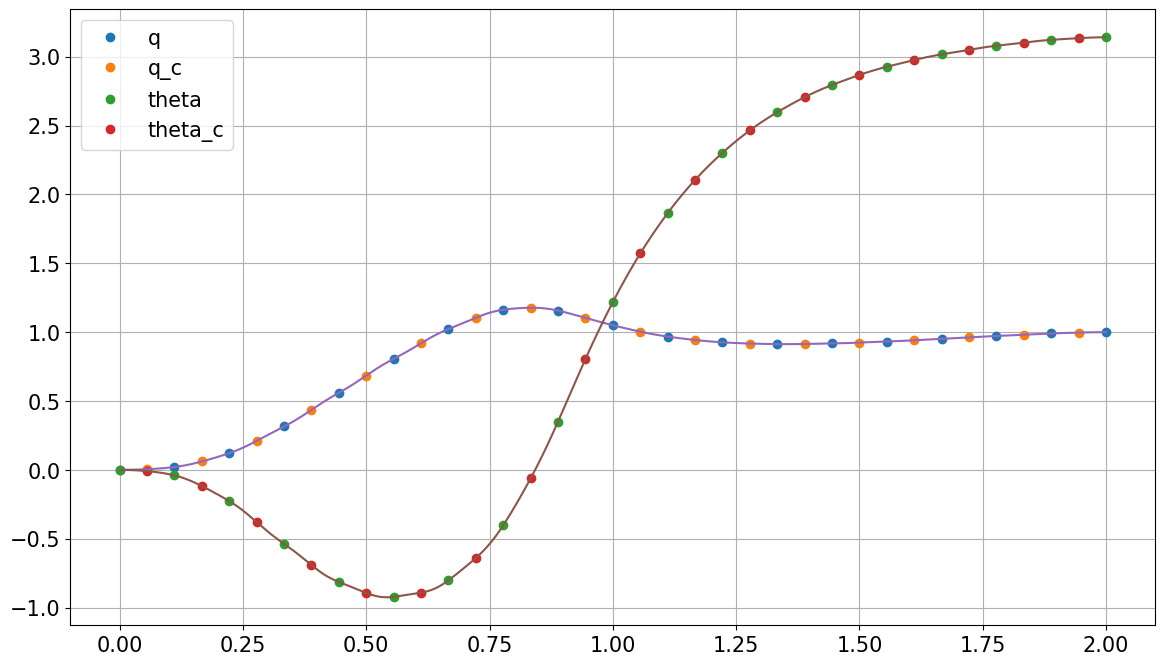

In [44]:

plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], marker = 'o', ls = '', label = labels[ii])
    #plt.plot(t_warm, q_warm, '--')
    if 'parab' in _res['scheme']:
        plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + '_c')
plt.plot(t_interp, q_arr)
plt.grid()
plt.legend()
if save:
        save_fig(
            problem_name = f'cartpole' ,
            graph_name = 'q',
            schemes_printed = [_res['scheme'],],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add =  f'3rd order scheme cost {cost_f}'
        )

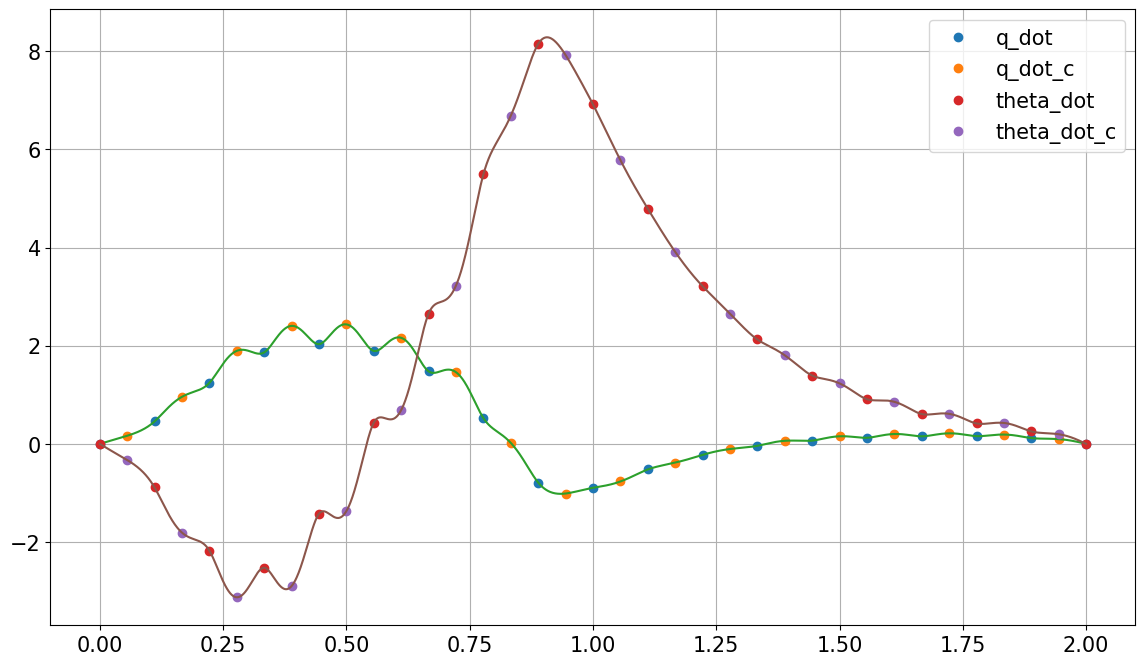

In [45]:
plt.figure(figsize=[14,8])
labels= ['q_dot', 'theta_dot']
v_res = _res['x'][:,2:]
for ii in range(2):
    plt.plot(_res['t'],v_res[:,ii], marker = 'o', ls = '', label = labels[ii])
    if 'parab' in _res['scheme']:
        plt.plot(_res['t_c'],_res['v_c'][:,ii], 'o', label = labels[ii] + '_c')
    #plt.plot(t_warm, v_warm, '--')
    plt.plot(t_interp, v_arr[:,ii])
plt.grid()
plt.legend()
if save:
        save_fig(
            problem_name = f'cartpole' ,
            graph_name = 'v',
            schemes_printed = [_res['scheme'],],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add =  f'3rd order scheme cost {cost_f}'
        )

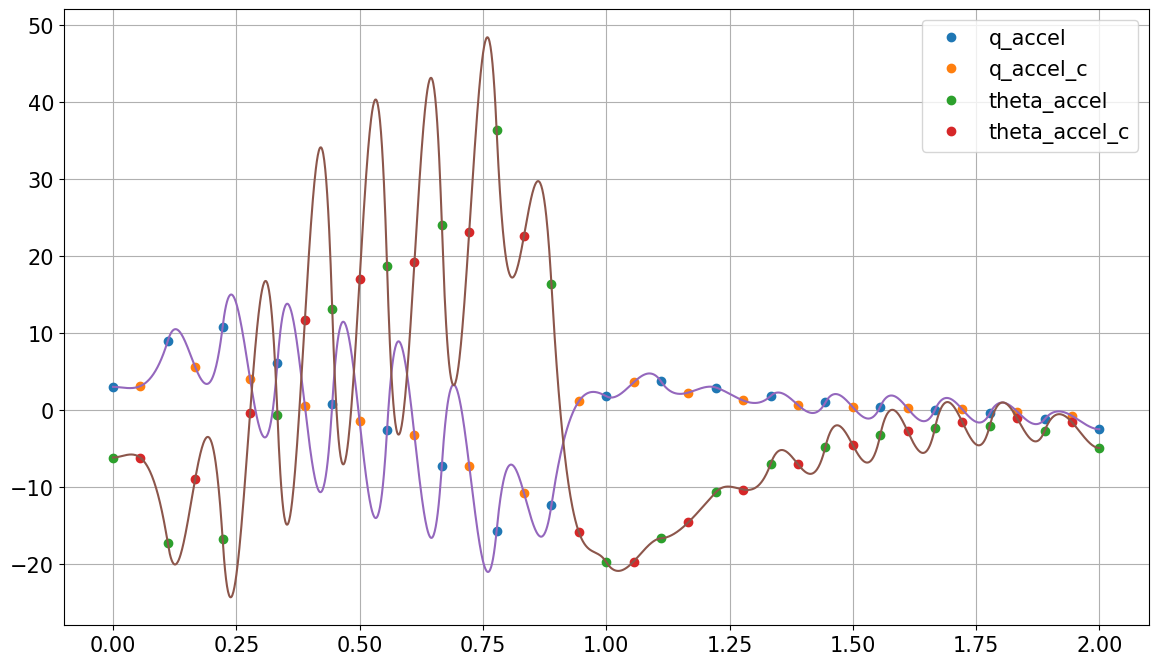

In [46]:
a_res = _res['x_d'][:,2:4]
plt.figure(figsize=[14,8])
labels= ['q_accel', 'theta_accel']
for ii in range(2):
    plt.plot(_res['t'],a_res[:,ii], marker = 'o', ls = '', label = labels[ii])
    if 'parab' in _res['scheme']:
        a_c_res = _res['x_d_c'][:,2:4]
        plt.plot(_res['t_c'],a_c_res[:,ii], 'o', label = labels[ii] + '_c')
plt.plot(t_interp, a_arr)
plt.grid()
plt.legend()
if save:
        save_fig(
            problem_name = f'cartpole' ,
            graph_name = 'a',
            schemes_printed = [_res['scheme'],],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add =  f'3rd order scheme cost {cost_f}'
        )

In [47]:
a_warm = np.gradient(v_warm, t_warm, axis = 0)
j_warm = np.gradient(a_warm, t_warm, axis = 0)

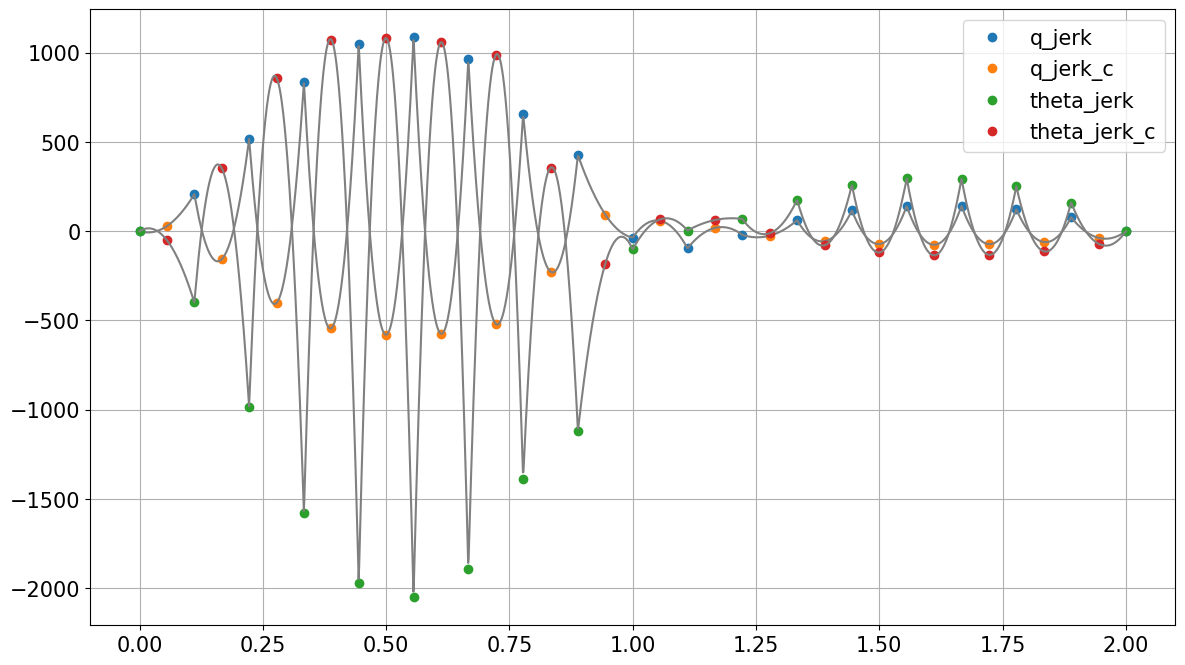

In [48]:
if order>2:
    j_res = _res['x_d'][:,4:6]
    plt.figure(figsize=[14,8])
    labels= ['q_jerk', 'theta_jerk']
    for ii in range(2):
        plt.plot(_res['t'],j_res[:,ii], marker = 'o', ls = '', label = labels[ii])
        if 'parab' in _res['scheme']:
            j_c_res = _res['x_d_c'][:,4:6]
            plt.plot(_res['t_c'],j_c_res[:,ii], 'o', label = labels[ii] + '_c')
        #plt.plot(t_warm[3:-3], j_warm[3:-3,ii], '--')
        plt.plot(t_interp, j_arr[:,ii], c = 'grey')
    plt.grid()
    plt.legend()
    if save:
            save_fig(
                problem_name = f'cartpole' ,
                graph_name = 'jerk',
                schemes_printed = [_res['scheme'],],
                save_format = save_format,
                N = n_col,
                q_counter = None,
                add =  f'3rd order scheme cost {cost_f}'
            )

In [49]:
snap_num = np.gradient(j_arr, t_interp, axis = 0)

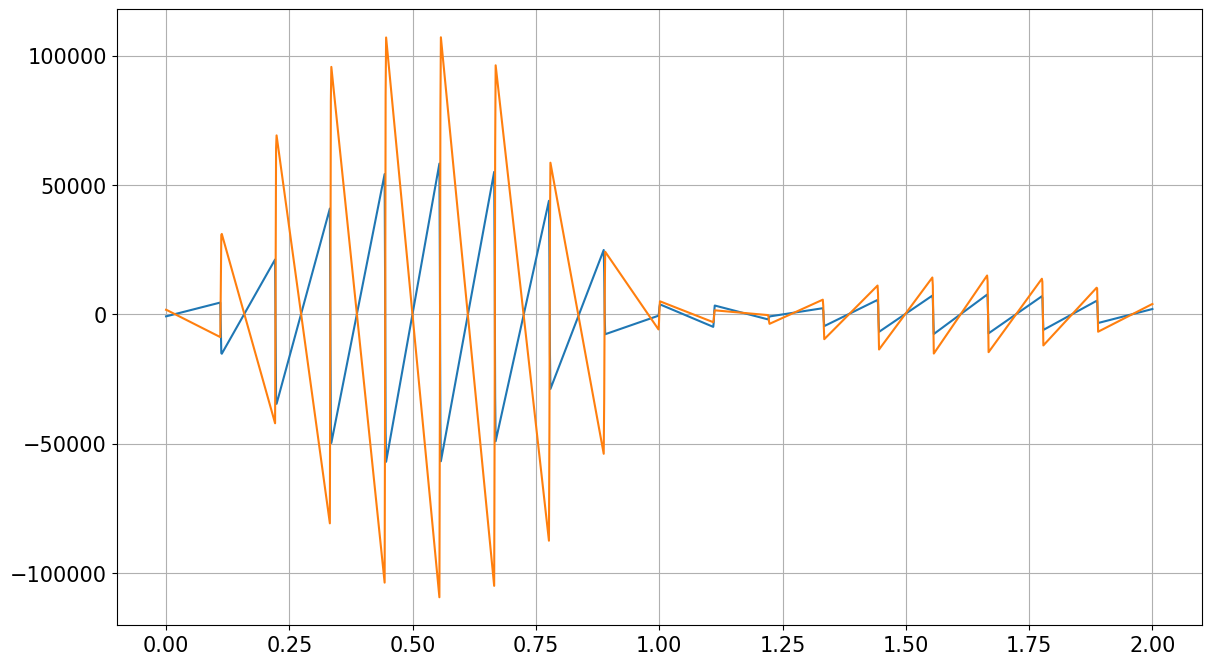

In [50]:
plt.figure(figsize=[14,8])

plt.plot(t_interp, snap_num)
plt.grid()

In [51]:
_res['x_d'][0, -2:]

array([-3.5794828e-30,  0.0000000e+00])

In [52]:
if order>3:
    s_res = _res['x_d'][:,6:8]
    plt.figure(figsize=[14,8])
    labels= ['q_snap', 'theta_snap']
    for ii in range(2):
        plt.plot(_res['t'],s_res[:,ii], marker = 'o', ls = '', label = labels[ii])
        if 'parab' in _res['scheme']:
            s_c_res = _res['x_d_c'][:,6:8]
            plt.plot(_res['t_c'],s_c_res[:,ii], 'o', label = labels[ii] + '_c')
    plt.plot(t_interp, s_arr)
    plt.grid()
    plt.legend()
    if save:
            save_fig(
                problem_name = f'cartpole' ,
                graph_name = 'snap',
                schemes_printed = [_res['scheme'],],
                save_format = save_format,
                N = n_col,
                q_counter = None,
                add =  f'3rd order scheme cost {cost_f}'
            )

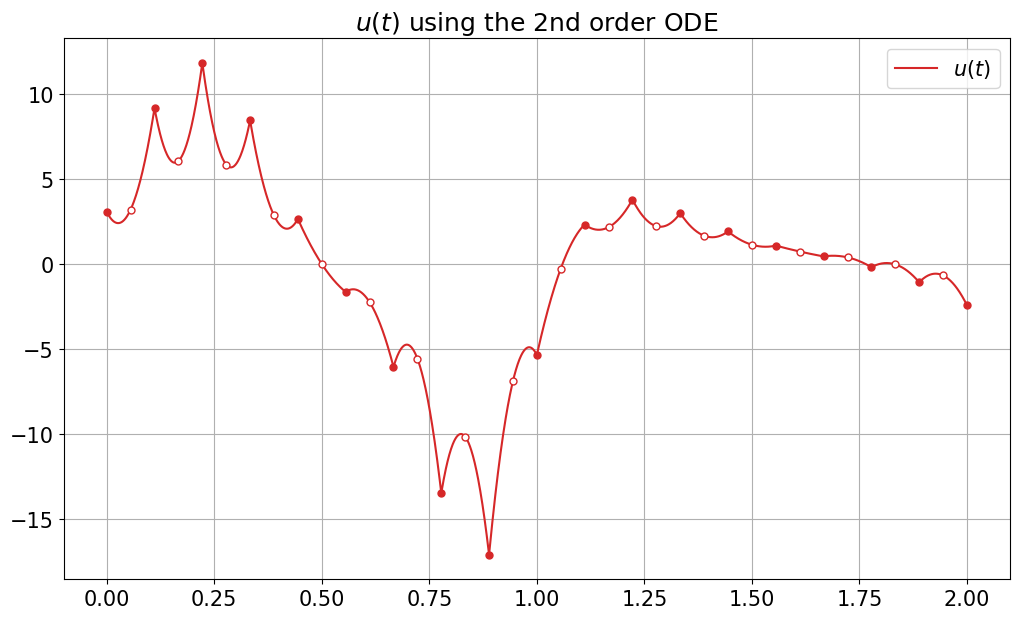

In [54]:
plt.figure(figsize=oct_fig_size)

if order >=2:
    color = sch_to_color('hsn_parab')
else:
    color = sch_to_color('hs_parab')
    
plt.plot(t_interp, u_arr, c = color, label = '$u(t)$')
plt.plot(_res['t'],_res['u'], 'o', ms =marker_size, c = color)
if 'parab' in scheme:
    plt.plot(_res['t_c'],_res['u_c'], 
                     'o', mec =color, ms =marker_size, mfc = 'w',
                     #label = 'u' + '_c'
                    )
plt.grid()
plt.legend()

if fixed_y_scale:
    y_lims = [-16, 11]
    plt.ylim(y_lims)

plt.title(r'$u(t)$' + f' using the 2nd order ODE')
plt.tight_layout(pad=0.0)

if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'u',
            schemes_printed = [scheme + f'_{order}'],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add = f'3rd order scheme cost {cost_f} init {x0}',
        )

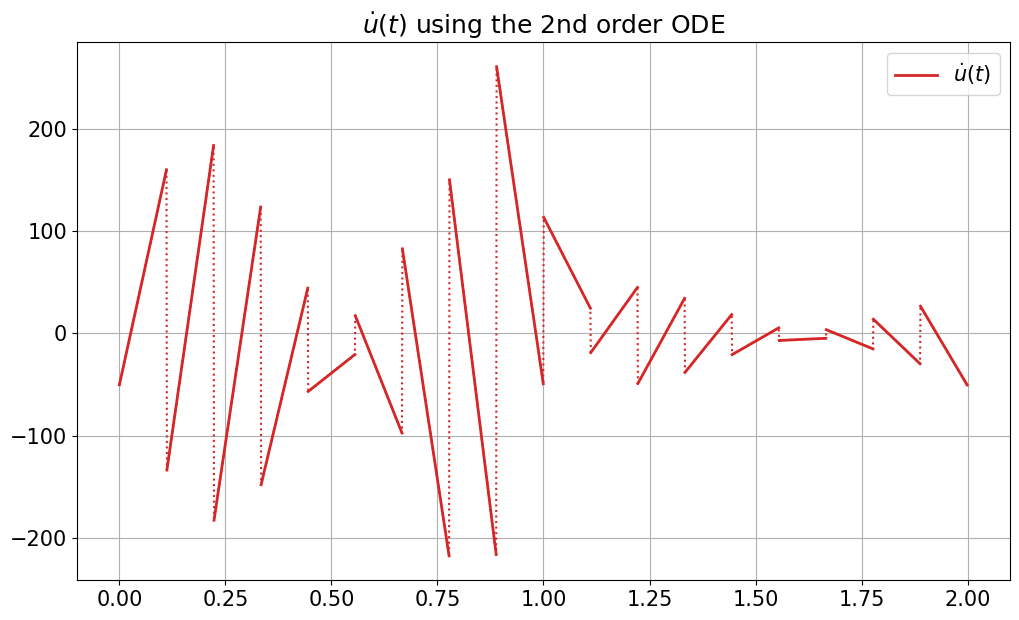

In [55]:
plt.figure(figsize=oct_fig_size)


if order >=2:
    color = sch_to_color('hsn_parab')
else:
    color = sch_to_color('hs_parab')
    
plt.grid()
plt.plot(t_interp, u_d_arr, ':', c = color)
plot_by_segments(
        t_arr = t_interp,
        y_plot = u_d_arr,
        label = '$\dot{u}(t)$',
        N = n_col,
        end_t = 2,
        plot_dict = {
            'c': color,
            'lw':2,
        }
    )

if fixed_y_scale:
    y_lims = [-78, 95]
    plt.ylim(y_lims)
    
plt.legend()
plt.title(r'$\dot{u}(t)$'+ f' using the 2nd order ODE')
plt.tight_layout(pad=0.0)

if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'u_dot',
            schemes_printed = [scheme + f'_{order}'],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add = f'3rd order scheme cost {cost_f} init {x0}',
        )

scheme = 'hs_mod_parab'
N = 25
xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, 'lin', 1)

xx_interp, uu_interp = interpolated_array(
    X = xx,
    U = uu,
    F = F_nump,
    h = 2/N,
    t_array = np.linspace(0, 2, 2000),
    params = params,
    scheme = "hs_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : uu_c}
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N+1),uu[:], 'o',label = '$u_k$ points')
plt.plot(np.linspace(0,2,2*N+1)[1::2],uu_c, 'o',label = '$u_c$ points')
plt.plot(np.linspace(0,2,2000),uu_interp, label = 'interpolation')
plt.grid()
plt.legend()
plt.title('Cart-pole U(t) for 2nd order Hermite Simpson with N = 25')
labels = ['q1','q2','v1','v2']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,2,N+1),xx[:,ii], 'o',label = f'${labels[ii]}_k$ points')
    plt.plot(np.linspace(0,2,2000),xx_interp[:,ii], label = 'interpolation')
    plt.grid()
    plt.legend()
    plt.title(f'Cart-pole {labels[ii]}(t) for 2nd order Hermite Simpson with N = 25')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

def sch_to_lab(sch):
    label_dict = {
        'hs': 'HS-1-Toputto',
        'hs_mod': 'HS-2-Toputto',
        'hs_parab': 'HS-1',
        'hs_mod_parab': 'HS-2',
        'trapz':'TZ-1',
        'trapz_mod':'TZ-2'
    }
    return label_dict[sch]

def sch_to_long_label(sch):
    titles = ['Hermite Simpson',
          '2nd order Hermite Simpson',
          'Trapezoidal',
          '2nd order Trapezoidal',
          'Hermite Simpson (Toputto)',
          '2nd order Hermite Simpson (Toputto)',]
    schemes = ['hs_parab', 'hs_mod_parab','trapz', 'trapz_mod', 'hs', 'hs_mod']
    lname_dict = {}
    for ii in range(6):
        lname_dict[schemes[ii]] = titles[ii]
    return lname_dict[sch]
        

def sch_to_color(sch):
    color_dict = {}
    for ii, sc_name in enumerate(['hs_parab', 'trapz_mod', 'trapz', 'hs_mod_parab','hs', 'hs_mod']):
        color_dict[sc_name] = f'C{ii}'
    return color_dict[sch]

def scheme_kwargs(sch, longlabel=False):
    kwargs = {'marker' :'o', 'c':sch_to_color(sch)}
    if longlabel:
        kwargs['label'] = sch_to_long_label(sch)
    else:
        kwargs['label'] = sch_to_lab(sch)
    return kwargs

## Sistematic comparison of schemes for different values of N

Now let's solve the problem with different methods.

### Caution!

Executing the next cell may require some time!

In [238]:
schemes = [
    #'LG2',
    'hsn_parab',
    'trapz_n',
    #'TD_LG',
    #'TD_CG',
    #'LG',
    #'LGR',
    #'LGL',
    #'CG',
    #'BU_LG',
    #'BU_LGR',
    #'BU_LGL',
    #'BU_CG',
    #'TD_LG',
    #'TD_LGR',
    #'TD_LGL',
    #'TD_CG',
] #If you defined a custom function, name your scheme here
ini_guess = 'lin'
cost_f = 'j+u'
x0 = 'qv'
solve_repetitions = 2 #Increase this number to get more reliable values of execution times
N_arr = [
    5, 7, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50,
    55, 60, 70, 80, 90, 100,
    #110, 120, 125, 130, 140, 150, 160, 170, 175, 180, 190, 200, 220, 225, 240, 250, 260, 275,
    #280, 300,]# 325, 350, 375, 400,]# 425, 450, 475, 500, 525, 550, 575, 600
]# You can increase the numbers here, but it will take more time
#N_arr = [50, 60,]


results = {}

for scheme in schemes:
        for order in range(3,4):
            if scheme == 'LG2' and order != 2:
                continue
            if scheme in ['LG', 'LGL', 'LGR', 'CG', 'CGL', 'CGR'] and order != 1:
                continue
            key = scheme + f'_{order}'
            results[key] = {'N_arr':N_arr}
            results[key]['scheme'] = scheme
            results[key]['order'] = order
    
                       
for N in N_arr:
    print(f'\tN = {N}')
    for scheme in schemes:
        for order in range(3,4):
            if scheme == 'LG2' and order != 2:
                continue
            if scheme in ['LG', 'LGL', 'LGR', 'CG', 'CGL', 'CGR'] and order != 1:
                continue
            key = scheme + f'_{order}'
            print(f'Problem: {key}, ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
            try:
                results[key][N] = casadi_cartpole(
                scheme,
                N, 
                ini_guess=ini_guess,
                cost_f = cost_f,
                x0 = x0,
                solve_repetitions=solve_repetitions,
                order = order,
                silent=True, 
                verbose=False)
            except RuntimeError: 
                results[key][N] = None
                print('ATTEMPT FAILED!!')
                results[key][N] = copy(casadi_cartpole(
                    scheme,
                    20, 
                    'lin',
                    solve_repetitions=solve_repetitions,
                    order = 2,
                    silent=True, 
                    verbose=False))
                for item in results[key][N]:
                    try:
                        results[key][N][item] = results[key][N][item]*np.nan
                    except TypeError:
                        results[key][N][item] = np.nan
        


	N = 5
Problem: hsn_parab_3,  13:31:53 
Problem: trapz_n_3,  13:31:53 
	N = 7
Problem: hsn_parab_3,  13:31:53 
Problem: trapz_n_3,  13:31:53 
	N = 10
Problem: hsn_parab_3,  13:31:53 
Problem: trapz_n_3,  13:31:53 
	N = 12
Problem: hsn_parab_3,  13:31:53 
Problem: trapz_n_3,  13:31:53 
	N = 15
Problem: hsn_parab_3,  13:31:54 
Problem: trapz_n_3,  13:31:54 
	N = 20
Problem: hsn_parab_3,  13:31:54 
Problem: trapz_n_3,  13:31:54 
	N = 25
Problem: hsn_parab_3,  13:31:54 
Problem: trapz_n_3,  13:31:55 
	N = 30
Problem: hsn_parab_3,  13:31:55 
Problem: trapz_n_3,  13:31:55 
	N = 35
Problem: hsn_parab_3,  13:31:55 
Problem: trapz_n_3,  13:31:56 
	N = 40
Problem: hsn_parab_3,  13:31:56 
Problem: trapz_n_3,  13:31:56 
	N = 45
Problem: hsn_parab_3,  13:31:56 
Problem: trapz_n_3,  13:31:57 
	N = 50
Problem: hsn_parab_3,  13:31:57 
Problem: trapz_n_3,  13:31:58 
	N = 55
Problem: hsn_parab_3,  13:31:58 
Problem: trapz_n_3,  13:31:59 
	N = 60
Problem: hsn_parab_3,  13:31:59 
Problem: trapz_n_3,  13:3

In [239]:
for key in results.keys():
        _c = []
        _cpudt = []
        _iters = []
        for N in results[key]['N_arr']:
            _c.append(results[key][N]['cost'])
            _cpudt.append(results[key][N]['cpudt'])
            _iters.append(results[key][N]['iter_count'])
        results[key]['cost'] = np.array(_c)
        results[key]['cpudt'] = np.array(_cpudt)
        results[key]['iter_count'] = np.array(_iters)

Text(0.5, 1.0, 'Final traj cost')

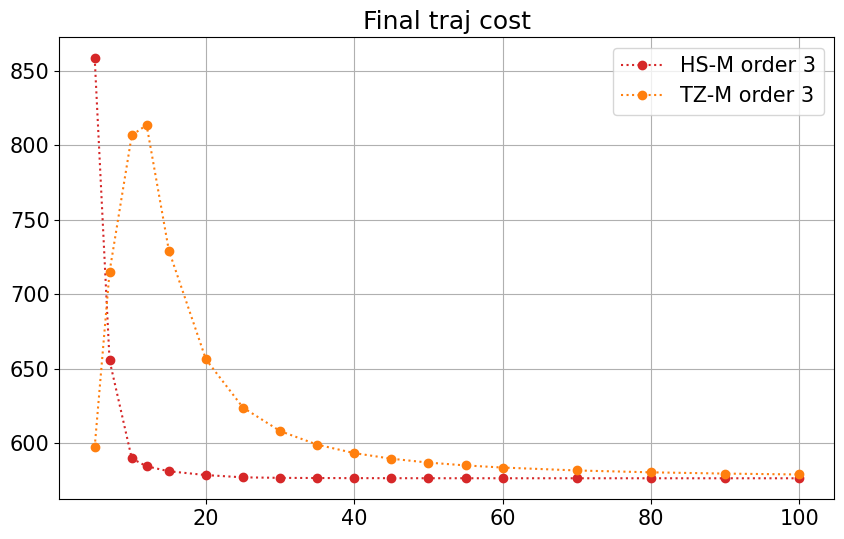

In [195]:
plt.figure(figsize=oct_fig_size)
for key in results.keys():
    scheme = results[key]['scheme']
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'], results[key]['cost'][:], **plot_kw)
#plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Final traj cost')

N = 60
scheme = 'BU_LG'
plt.figure(figsize=[14,8])

for ii in range(1,3):
    key = scheme + f'_{ii}'
    uu_pol, q_n_der_pols = chords.bu_pseudospectral.Polynomial_interpolations_BU(
        results[key][N]['x_d'],
        results[key][N]['x'][0,:],
        results[key][N]['u'],
        scheme,
        ii,
        0,
        2,
        N
    )
    

    plt.plot(results[key][N]['t_col'],results[key][N]['u'][:], 'o', label = 'u ' + key)
    plt.plot(t_interp_arr, uu_pol(t_interp_arr), 'grey',':')
plt.grid()
plt.legend()
points_ii = np.array([0, 12, 27, 33, 59])
uu_in = results[key][N]['u'][points_ii]
tt_in = results[key][N]['t_col'][points_ii]
plt.plot(tt_in,uu_in, '-', label = 'u interp')

## Dynamic Error

Now we can compute the dynamic errors for each case

In [196]:
def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

In [197]:
import chords
import importlib
importlib.reload(chords.td_pseudospectral)
importlib.reload(chords.util)
importlib.reload(chords.pseudospectral)
importlib.reload(chords.analysis)
importlib.reload(chords)
from chords.util import sch_to_color, sch_to_lab, scheme_kwargs

from chords.td_pseudospectral import dynamic_error_TD, interpolations_deriv_TD_pseudospectral

In [198]:
from chords.analysis import dynamic_errors

In [199]:
results.keys()

dict_keys(['hsn_parab_3', 'trapz_n_3'])

In [204]:
n_interp = 2000
for key in results.keys():
    scheme = results[key]['scheme'] 
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        res = results[key][N]
        if res['scheme'] is np.nan:
            print('\t\tNaN in Scheme')
            nan_arr = np.zeros([n_interp, 3])*np.nan
            errors= {
                'compat_err_1_interp': nan_arr,
                'dyn_err_interp' : nan_arr,
            }
            res['error'] = errors
        else:
            errors = dynamic_errors(
                res,
                F_nump,
                dynamics_error_mode = 'q',
                problem_order=3,
                scheme_order=3,
                x_interp=None,
                u_interp=None,
                n_interp=n_interp,
            )
        dyn_err_q = errors['compat_err_1_interp']
        dyn_err_3 = errors['dyn_err_interp']
        t_arr = np.linspace(0,2, n_interp)
        tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
        tot_dyn_err_3 = total_state_error(t_arr, dyn_err_3)
        errors['err_q'] = tot_dyn_err_q
        errors['err_3'] = tot_dyn_err_3
            

Problem: hsn_parab_3
	N = 5


TypeError: _lambdifygenerated() takes 9 positional arguments but 11 were given

In [205]:
def arr_mod(x):
    x_1 = np.sum(x*x, axis=1)
    return np.sqrt(x_1)
def arr_sum(x):
    return np.sum(np.abs(x), axis = 1)
def arr_max(x):
    return np.max(np.abs(x), axis = 1)

In [41]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    err_q_acum = []
    err_2_acum = []
    cpudt = []
    for N in N_arr:
        errors = results[key][N]['error']
        err_q_acum.append(errors['err_q'])
        err_2_acum.append(errors['err_2'])
    results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
    results[key]['err_2_acum'] = np.array(err_2_acum, dtype = float)
    

Problem: hsn_parab_1
Problem: hsn_parab_2
Problem: trapz_n_1
Problem: trapz_n_2
Problem: LG_1
Problem: LGR_1
Problem: LGL_1
Problem: BU_LG_1
Problem: BU_LG_2
Problem: BU_LGR_1
Problem: BU_LGR_2
Problem: BU_LGL_1
Problem: BU_LGL_2


for key in results.keys():
    scheme = results[key]['scheme']
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        _case = results[key][N]
        t_arr = np.linspace(0,
                        _case['t'][-1],
                        _case['dyn_err_2'].shape[0])
            
        _derivs = interpolations_deriv_TD_pseudospectral(
            _case['q_constr'],
            _case['x'],
            _case['x_d'],
            scheme,
            deriv_order = 1,
            t0 = 0,
            tf = _case['t'][-1],
            n_coll=_case['u'].shape[0],
            scheme_order = 2,
            x_interp="pol",
            n_interp=n_interp,
        )
        _accels = _derivs[:, 2:]
        
        #_case[f'sum_dyn_err_2_arr'] = arr_sum(_case['dyn_err_2']) # NOT VALID
        _case[f'sum_dyn_err_2_arr'] = None
        _case['a_arr'] = _accels
        _case['a_abs_mean_by_component'] = np.mean(np.abs(_accels), axis = 0)
        _case['a_abs_mean'] = np.mean(np.abs(_accels))
        #_case['a_abs_sum_arr'] = arr_sum(_accels) # NOT VALID
        _case['a_abs_sum_arr'] = None
        
        _case['rel_dyn_err_2_arr_by_instant_a_sum'] = arr_sum(_case['dyn_err_2']/_case['a_arr'])
        _case['rel_dyn_err_2_arr_by_total_mean_sum'] = None
        _case['rel_dyn_err_2_arr_by_mean_by_component_sum'] = arr_sum(_case['dyn_err_2']/_case['a_abs_mean_by_component'])
        _case['rel_dyn_err_2_arr_by_a_sum_arr_sum'] = None

def plot_by_segments(results, schemes, N, thing_to_plot, title, ylabel, component = 'all'):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for scheme in schemes:
        t_arr = np.linspace(0,
                        results[scheme][N]['t'][-1],
                        results[scheme][N][thing_to_plot].shape[0])
        interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = results[scheme][N][thing_to_plot]
            if component != 'all':
                y_plot = y_plot[:, component]
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                '-', c = sch_to_color(scheme),
                label = sch_to_lab(scheme) if cut_p == 0 else None)
            cut_p = jj
        if 'hs' in scheme:
            plot_coll_p = True
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', ms=5, label = 'knot & collocation points')
    if plot_coll_p:
        plt.plot(results[scheme][N]['t_c'], 
                     np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                     label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout(pad = 0.0)
    #plt.yscale('log')
    #plt.savefig(f'2d_order/5_link_HS_N{N}_second_order_dynamic_error.pdf', format='pdf')

In [42]:
from chords.util import plot_by_segments

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [43]:
results[key][N].keys()

dict_keys(['cpudt', 'iter_count', 'cost', 'opti_stats', 'scheme_mode', 'n_q', 'n_u', 'solve_order', 'params', 'n_coll', 'scheme', 'x', 'x_like_u', 'x_d', 'x_d_like_u', 'u', 't', 't_col', 'tau', 'tau_col', 'lam', 'u_like_x', 'q', 'q_like_u', 'v', 'v_like_u', 'a', 'a_like_u', 'interpolations', 'error'])

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_int'][cut_p:jj,ii], '-', c = sch_to_color(key), label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

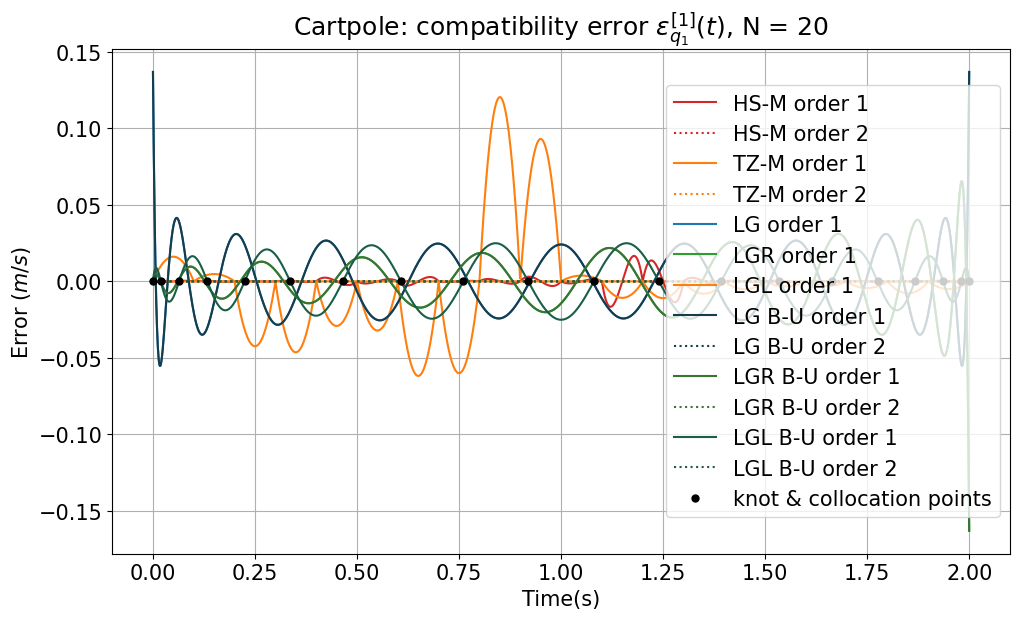

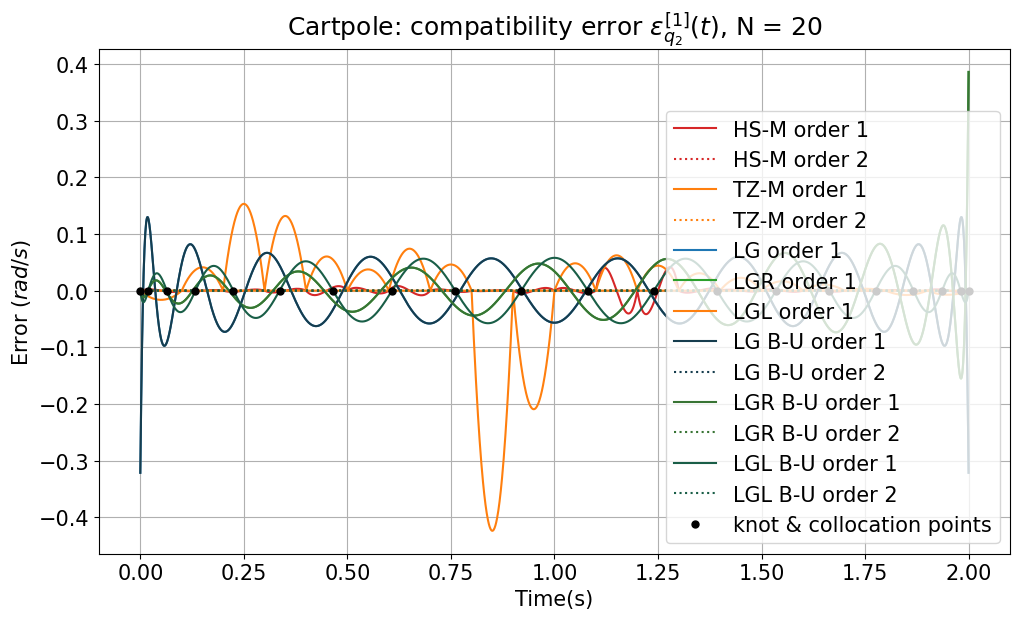

In [44]:
#schemes = ['trapz', 'trapz_mod']
ylabels = ['Error $(m/s)$','Error $(rad/s)$']
N = 20
save = False

for component in range(2):
    plt.figure(figsize=oct_fig_size)
    t_arr = np.linspace(
            0, results[key][N]["t"][-1], results[key][N]['error']['compat_err_1_interp'].shape[0]
        )
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['marker'] = ''
        plt.plot(t_arr, results[key][N]['error']['compat_err_1_interp'][:,component], **plot_kw)
    plt.plot(
        results[key][N]["t"],
        np.zeros(len(results[key][N]["t"])),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    plt.legend()
    plt.grid()
    plt.title(r'Cartpole: compatibility error $\varepsilon^{[1]}_{q_'+f'{component+1}}}(t)$, N = {N}')
    plt.xlabel("Time(s)")
    plt.ylabel(ylabels[component])
    plt.tight_layout(pad=0.0)
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'first_order_dyn_error',
            schemes_printed = schemes,
            save_format = 'pdf',
            N = N,
            q_counter = component,
        )
    

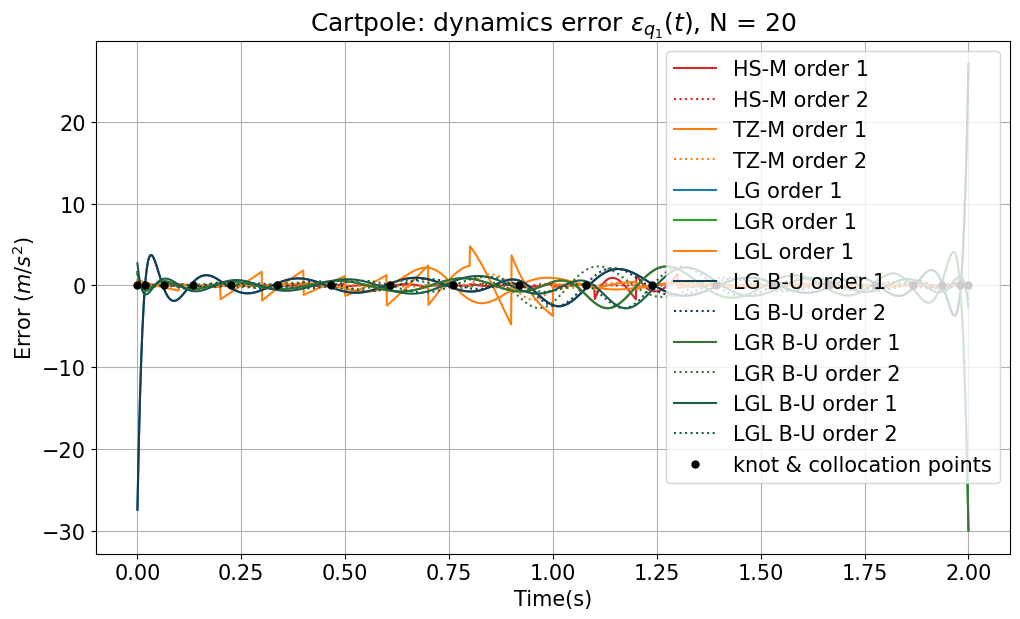

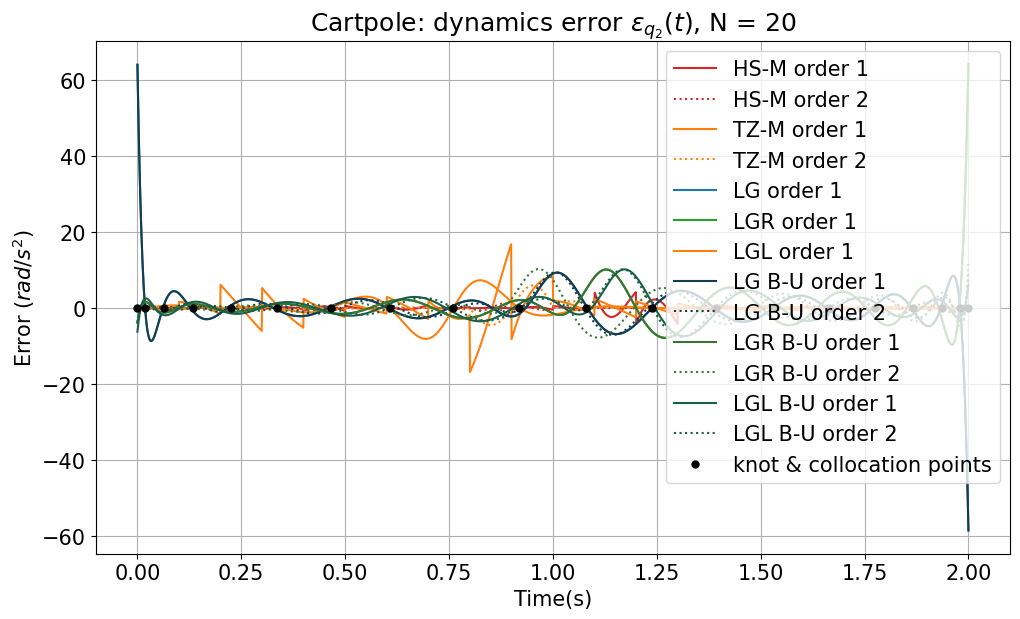

In [45]:
ylabels = ['Error $(m/s^2)$','Error $(rad/s^2)$']
N = 20
for component in range(2):
    plt.figure(figsize=oct_fig_size)
    t_arr = np.linspace(
            0, results[key][N]["t"][-1], results[key][N]['error']['dyn_err_interp'].shape[0]
        )
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['marker'] = ''
        plt.plot(t_arr, results[key][N]['error']["dyn_err_interp"][:,component], **plot_kw)
    plt.plot(
        results[key][N]["t"],
        np.zeros(len(results[key][N]["t"])),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    plt.legend()
    plt.grid()
    plt.title(r'Cartpole: dynamics error $\varepsilon_{q_'+f'{component+1}}}(t)$, N = {N}')
    plt.xlabel("Time(s)")
    plt.ylabel(ylabels[component])
    plt.tight_layout(pad=0.0)
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'second_order_dyn_error',
            schemes_printed = schemes,
            save_format = 'pdf',
            N = N,
            q_counter = component,
        )

In [46]:
results.keys()

dict_keys(['hsn_parab_1', 'hsn_parab_2', 'trapz_n_1', 'trapz_n_2', 'LG_1', 'LGR_1', 'LGL_1', 'BU_LG_1', 'BU_LG_2', 'BU_LGR_1', 'BU_LGR_2', 'BU_LGL_1', 'BU_LGL_2'])

In [47]:
from chords.util import save_fig

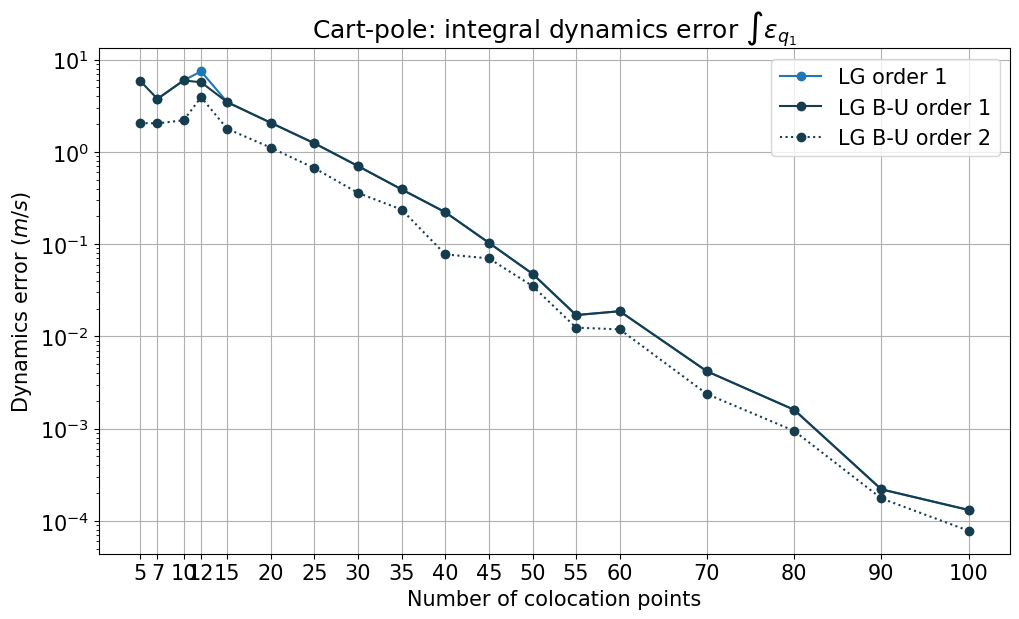

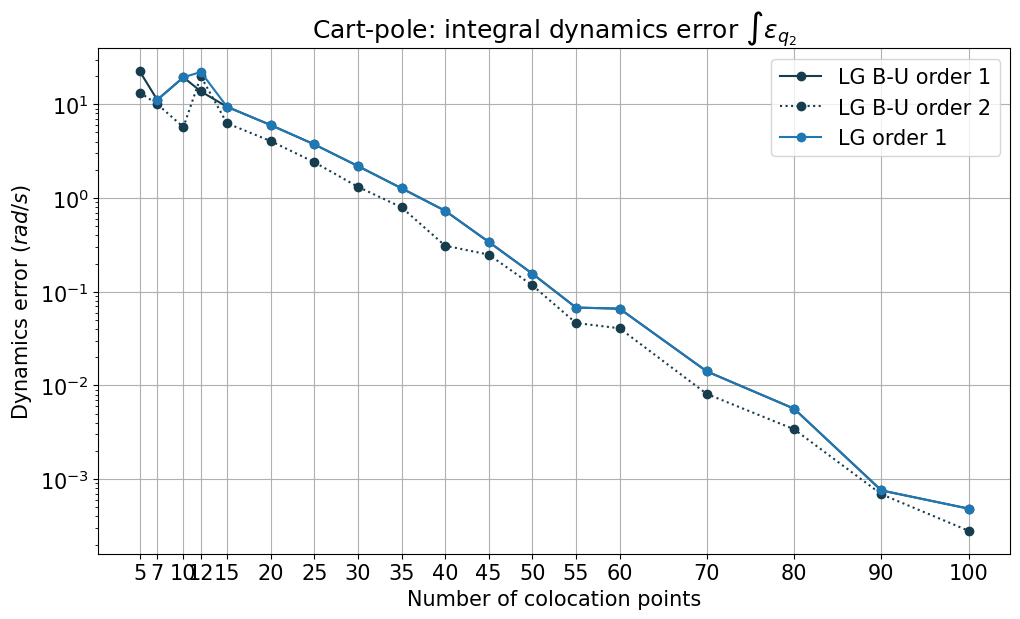

In [48]:
data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
schemes = [
    #'LG2_2',
    #'hsn_parab_1',
    #'hsn_parab_2',
    'LG_1',
    #'LGR_1',
    #'LGL_1',
    #'CG_1',
    'BU_LG_1',
    'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2'
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_CG_1',
    #'TD_CG_2',
]


save = True
#save = False

data_key = data_array[2]
for qq in range(2):
    plt.figure(figsize=oct_fig_size)
    plt.title(r'Cart-pole: integral dynamics error $\int\varepsilon_{q_'+f'{qq+1}}}$')
    for key in schemes: #results.keys():
        scheme = results[key]['scheme']
        #if "C" in scheme:
            #continue
            #pass
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,
             results[key][data_key],
             **plot_kw)
        else:
            plt.plot(N_arr,
             results[key][data_key][:,qq],
             **plot_kw)
    plt.yscale('log')
    ticks = np.array(results[key]['N_arr'])
    #ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of colocation points')
    plt.grid()
    plt.legend()#loc = 'lower left'
    units = 'm/s' if qq == 0 else'rad/s'
    plt.ylabel(f'Dynamics error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'integ_dyn_error',
            schemes_printed = schemes,
            save_format = 'pdf',
            N = None,
            q_counter = qq,
        )

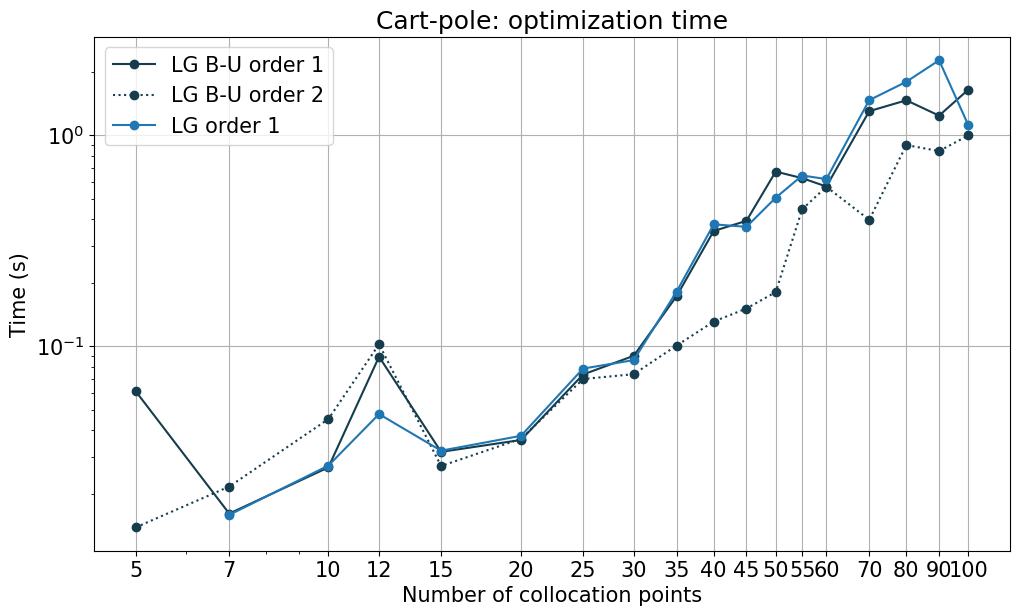

In [49]:

plt.figure(figsize=[10,6])
for key in schemes:
    scheme = results[key]['scheme']
    #if "C" not in scheme:
            #continue
            #pass
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'],
             results[key][f'cpudt'],
             **plot_kw)
plt.grid()
plt.legend()
plt.title('Cart-pole: optimization time')
plt.xlabel('Number of collocation points')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
#ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
#ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'opt_time',
        schemes_printed = schemes,
        save_format = 'pdf',
        N = None,
        q_counter = None,
    )

# Here we print the data shown in Table II of the paper
for scheme in ['trapz', 'trapz_mod', 'hs_parab', 'hs_mod_parab']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 2:', results[key][N]['err_2'])

## Animation

from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 200

def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(72)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    #circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    #ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
        
    xx_interpolated, uu_interpolated = interpolated_array(
        X,
        U,
        F = F_nump,
        h = 2/(N-1),
        t_array = np.linspace(0, 2, 5*(N-1)+1),
        params = params,
        scheme = 'hs_mod_parab',
        u_scheme = 'parab',
        scheme_params = {'u_c' : results['hs_mod_parab_lin'][N-1]['u_c']}
    )
    x_0_interp = xx_interpolated[:,0]
    y_0_interp = np.zeros_like(x_0_interp)
    x_1_interp = x_0_interp + l_n*np.sin(xx_interpolated[:,1])
    y_1_interp = y_0_interp - l_n*np.cos(xx_interpolated[:,1])
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        #circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        #circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1_interp[:5*i+1], y_1_interp[:5*i+1])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    frame_indices = np.concatenate((np.zeros(10, dtype=int), np.arange(0, N, 1), np.ones(15, dtype=int)*(N-1)))
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_indices, interval=20, 
                               blit=True)
    return anim

anim = create_anim(results['hs_parab_lin'][25]['x'], results['hs_parab_lin'][25]['u'], params)

HTML(anim.to_jshtml())

f = r"cartpole_animation.mp4" 
writervideo = animation.FFMpegWriter(fps=12) 
# If you are running the notebook locally and want to save the animation,
# uncomment the next line
#anim.save(f, writer=writervideo)